In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder
import datetime
import pickle
import math
from tqdm import tqdm
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score,KFold
from scipy.stats import skew, norm
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


pd.set_option('display.max_columns', None) # no truncate columns

In [50]:
# Environment settings
data_path_out = 'Data/output/'
    
# Deserialize previously saved data from "data-visualization"
with open(data_path_out + 'train_pp.obj', 'rb') as file:
    all_train = pickle.load(file)

In [51]:
all_train['year'] = all_train.Date.dt.year
all_train['month'] = all_train.Date.dt.month
all_train['day_of_month'] = all_train.Date.dt.day
all_train['day_of_week'] = all_train.Date.dt.dayofweek
all_train['day_of_year'] = all_train.Date.dt.dayofyear
all_train['week_of_year'] = all_train.Date.dt.weekofyear

## One Hot Encoding

In [52]:
all_train = pd.get_dummies(all_train,columns= ['Region','AssortmentType','StoreType','Events'])

### Drop now useless variables

In [53]:
all_train = all_train.drop(labels = ['NumberOfCustomers'],axis=1)
all_train = all_train.drop('Date',axis=1)

In [54]:
# train = all_train[all_train['Date'] < '01-02-2018']
# test = all_train[all_train['Date'] >= '01-02-2018']
# train = train[train.StoreID == 1000]
# test = test[test.StoreID == 1000]
# y_train = train.NumberOfSales
# x_train = train.drop('NumberOfSales',axis = 1)
# y_test = test.NumberOfSales
# x_test = test.drop('NumberOfSales',axis = 1)

# x_train = x_train.drop('Date',axis=1)
# x_test = x_test.drop('Date',axis=1)

In [55]:
# params = {
#     # Parameters that we are going to tune.
#     'max_depth':6,
#     'min_child_weight': 1,
#     'eta':.3,
#     'subsample': 1,
#     'colsample_bytree': 1,
#     # Other parameters
#     'objective':'reg:linear',
# }

In [14]:
results = {}
for storeid in all_train.StoreID.unique():
    train = all_train[all_train.StoreID == storeid]
    y_train = train.NumberOfSales
    x_train = train.drop('NumberOfSales',axis = 1)
    
    model = XGBRegressor(silent=False)
    kfold = KFold(n_splits=10,shuffle = True, random_state=7)
    results[storeid] = cross_val_score(model, x_train, y_train,scoring='r2', cv=kfold)
    print("Cross-validation for %d -> score: %.4f with +/- %.4f"%(storeid,results[storeid].mean(),results[storeid].std()))

Cross-validation for 1000 -> score: 0.9124 with +/- 0.0266
Cross-validation for 1001 -> score: 0.7783 with +/- 0.1368
Cross-validation for 1002 -> score: 0.9429 with +/- 0.0115
Cross-validation for 1003 -> score: 0.9292 with +/- 0.0267
Cross-validation for 1004 -> score: 0.9376 with +/- 0.0246
Cross-validation for 1005 -> score: 0.9422 with +/- 0.0190
Cross-validation for 1006 -> score: 0.9059 with +/- 0.0248
Cross-validation for 1007 -> score: 0.8984 with +/- 0.0410
Cross-validation for 1008 -> score: 0.9150 with +/- 0.0101
Cross-validation for 1009 -> score: 0.9443 with +/- 0.0222
Cross-validation for 1010 -> score: 0.9247 with +/- 0.0191
Cross-validation for 1011 -> score: 0.9336 with +/- 0.0282
Cross-validation for 1012 -> score: 0.9507 with +/- 0.0123
Cross-validation for 1013 -> score: 0.9476 with +/- 0.0206
Cross-validation for 1014 -> score: 0.9405 with +/- 0.0212
Cross-validation for 1015 -> score: 0.9236 with +/- 0.0273
Cross-validation for 1016 -> score: 0.8983 with +/- 0.04

Cross-validation for 1139 -> score: 0.9121 with +/- 0.0236
Cross-validation for 1140 -> score: 0.9464 with +/- 0.0168
Cross-validation for 1141 -> score: 0.9300 with +/- 0.0272
Cross-validation for 1142 -> score: 0.9314 with +/- 0.0212
Cross-validation for 1143 -> score: 0.9230 with +/- 0.0191
Cross-validation for 1144 -> score: 0.9389 with +/- 0.0136
Cross-validation for 1145 -> score: 0.9198 with +/- 0.0273
Cross-validation for 1146 -> score: 0.9224 with +/- 0.0248
Cross-validation for 1147 -> score: 0.9287 with +/- 0.0180
Cross-validation for 1148 -> score: 0.8763 with +/- 0.0485
Cross-validation for 1149 -> score: 0.9418 with +/- 0.0113
Cross-validation for 1150 -> score: 0.9393 with +/- 0.0213
Cross-validation for 1151 -> score: 0.9101 with +/- 0.0311
Cross-validation for 1152 -> score: 0.9151 with +/- 0.0225
Cross-validation for 1153 -> score: 0.9314 with +/- 0.0198
Cross-validation for 1154 -> score: 0.9248 with +/- 0.0279
Cross-validation for 1155 -> score: 0.9558 with +/- 0.01

Cross-validation for 1278 -> score: 0.9392 with +/- 0.0234
Cross-validation for 1279 -> score: 0.9287 with +/- 0.0350
Cross-validation for 1280 -> score: 0.9339 with +/- 0.0176
Cross-validation for 1281 -> score: 0.9389 with +/- 0.0296
Cross-validation for 1282 -> score: 0.9186 with +/- 0.0328
Cross-validation for 1283 -> score: 0.9301 with +/- 0.0203
Cross-validation for 1284 -> score: 0.9307 with +/- 0.0137
Cross-validation for 1285 -> score: 0.9105 with +/- 0.0571
Cross-validation for 1286 -> score: 0.9503 with +/- 0.0156
Cross-validation for 1287 -> score: 0.9571 with +/- 0.0149
Cross-validation for 1288 -> score: 0.9399 with +/- 0.0194
Cross-validation for 1289 -> score: 0.9359 with +/- 0.0150
Cross-validation for 1290 -> score: 0.9102 with +/- 0.0284
Cross-validation for 1291 -> score: 0.9037 with +/- 0.0302
Cross-validation for 1292 -> score: 0.9442 with +/- 0.0186
Cross-validation for 1293 -> score: 0.9314 with +/- 0.0265
Cross-validation for 1294 -> score: 0.9020 with +/- 0.03

Cross-validation for 1417 -> score: 0.9225 with +/- 0.0376
Cross-validation for 1418 -> score: 0.9373 with +/- 0.0319
Cross-validation for 1419 -> score: 0.9274 with +/- 0.0315
Cross-validation for 1420 -> score: 0.9302 with +/- 0.0489
Cross-validation for 1421 -> score: 0.9138 with +/- 0.0446
Cross-validation for 1422 -> score: 0.9154 with +/- 0.0250
Cross-validation for 1423 -> score: 0.9442 with +/- 0.0193
Cross-validation for 1424 -> score: 0.9613 with +/- 0.0095
Cross-validation for 1425 -> score: 0.9532 with +/- 0.0100
Cross-validation for 1426 -> score: 0.9292 with +/- 0.0231
Cross-validation for 1427 -> score: 0.9093 with +/- 0.0610
Cross-validation for 1428 -> score: 0.9450 with +/- 0.0094
Cross-validation for 1429 -> score: 0.8275 with +/- 0.0716
Cross-validation for 1430 -> score: 0.9506 with +/- 0.0096
Cross-validation for 1431 -> score: 0.9196 with +/- 0.0279
Cross-validation for 1432 -> score: 0.9066 with +/- 0.0219
Cross-validation for 1433 -> score: 0.9110 with +/- 0.03

Cross-validation for 1556 -> score: 0.9310 with +/- 0.0241
Cross-validation for 1557 -> score: 0.9146 with +/- 0.0241
Cross-validation for 1558 -> score: 0.9274 with +/- 0.0144
Cross-validation for 1559 -> score: 0.8241 with +/- 0.0757
Cross-validation for 1560 -> score: 0.9197 with +/- 0.0267
Cross-validation for 1561 -> score: 0.9403 with +/- 0.0181
Cross-validation for 1562 -> score: 0.9376 with +/- 0.0194
Cross-validation for 1563 -> score: 0.9526 with +/- 0.0190
Cross-validation for 1564 -> score: 0.8191 with +/- 0.0995
Cross-validation for 1565 -> score: 0.9426 with +/- 0.0249
Cross-validation for 1566 -> score: 0.9392 with +/- 0.0169
Cross-validation for 1567 -> score: 0.9190 with +/- 0.0227
Cross-validation for 1568 -> score: 0.9120 with +/- 0.0208
Cross-validation for 1569 -> score: 0.9450 with +/- 0.0224
Cross-validation for 1570 -> score: 0.9553 with +/- 0.0122
Cross-validation for 1571 -> score: 0.9241 with +/- 0.0155
Cross-validation for 1572 -> score: 0.9422 with +/- 0.01

Cross-validation for 1695 -> score: 0.9529 with +/- 0.0168
Cross-validation for 1696 -> score: 0.9475 with +/- 0.0143
Cross-validation for 1697 -> score: 0.9281 with +/- 0.0261
Cross-validation for 1698 -> score: 0.9487 with +/- 0.0156
Cross-validation for 1699 -> score: 0.9485 with +/- 0.0150
Cross-validation for 1700 -> score: 0.9357 with +/- 0.0212
Cross-validation for 1701 -> score: 0.9451 with +/- 0.0192
Cross-validation for 1702 -> score: 0.9481 with +/- 0.0141
Cross-validation for 1703 -> score: 0.9303 with +/- 0.0177
Cross-validation for 1704 -> score: 0.9259 with +/- 0.0205
Cross-validation for 1705 -> score: 0.9407 with +/- 0.0251
Cross-validation for 1706 -> score: 0.9507 with +/- 0.0152
Cross-validation for 1707 -> score: 0.9274 with +/- 0.0301
Cross-validation for 1708 -> score: 0.9445 with +/- 0.0244
Cross-validation for 1709 -> score: 0.9130 with +/- 0.0245
Cross-validation for 1710 -> score: 0.9299 with +/- 0.0256
Cross-validation for 1711 -> score: 0.8627 with +/- 0.04

In [31]:
df_results = pd.DataFrame.from_dict(results).T
df_results_mean = df_results.mean(axis=1)
df_results_mean[df_results_mean < 0.8]

1001    0.778329
1194    0.753815
1267    0.780241
1307    0.799880
1330    0.520917
1336    0.781744
1339    0.720012
1357    0.794068
1546    0.400251
1729    0.617553
dtype: float64

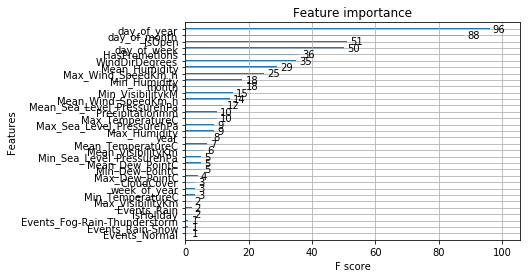

In [57]:
from xgboost import plot_importance
y_train = all_train[all_train.StoreID == 1000].NumberOfSales
x_train = all_train[all_train.StoreID == 1000].drop('NumberOfSales',axis = 1)
    
model = XGBRegressor(silent=False)
model.fit(x_train,y_train)
plot_importance(model)
